### mysql

In [15]:
# ! pip install mysql-connector-python-rf
import mysql.connector

mydb = mysql.connector.connect(
  host="10.41.241.230",
  port="30003",
  user="aoi_ai",
  password="finding_way_out",
)

mycursor = mydb.cursor()

In [33]:
mycursor.execute("SELECT * FROM P3.dip_prewave where component='AluCap' and path like '%/dip-prewave-saiap/%'")
test = mycursor.fetchall()
len(test)

37976

In [34]:
import os
for t in test:
    try:
        directory, filename = os.path.split(t[0])
        path = ''
        for d in directory.split(os.path.sep):
            try:
                x = int(d)
            except:
                continue
            if len(d)==4 and int(d)>0:
                path = t[0].replace(d, '2020'+d)
        if path == '':
            print(t)
            break
        else:
            try:
                file_url = '10.41.241.230:30038'+path
                sql = f"update P3.dip_prewave set path='{path}', file_url='{file_url}' where path='{t[0]}'"
                mycursor.execute(sql)
                mydb.commit()
            except Exception as e:
                print(e, t[0])
                break
    except Exception as e:
        print(e, t)
        break

## check db in dip-prewave-saiap

In [1]:
import os, glob
# /line/date/A4_result/PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
base_path = '/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/*/0808/*/*.png' 
img_list = glob.glob(base_path)
len(img_list)
# for i in img_list:
#     print(i)

257

In [11]:
import os
img_list = []
base_path = '/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/'
for root, dirs, files in os.walk(base_path):
    for img_file in files:
        if img_file.endswith(".png") or img_file.endswith(".bmp") or img_file.endswith(".jpg"):
            img_list.append(os.path.join(root, img_file))
len(img_list)

49617

In [17]:
ip_img_list = []
for i in img_list:
    if i.split('/')[-2] == 'InversePolarity':
        ip_img_list.append(i)
len(ip_img_list)

9

In [1]:
import sqlite3, sys
db_path = '/data/aoi-wzs-p3-dip-prewave-saiap/metadata.db'
con = sqlite3.connect(db_path)
c = con.cursor()

In [4]:
c.execute('select date from metadata order by date desc').fetchone()

('20200729',)

In [4]:
c.execute("""select component, count(*) from new_metadata group by component""").fetchall()

[('AluCap', 8380),
 ('ElecCap', 14092),
 ('L', 3066),
 ('PCI', 295),
 ('SATA', 1367)]

In [3]:
c.execute("""select component, count(*) from metadata group by component""").fetchall()

[('AluCap', 492843),
 ('ElecCap', 140070),
 ('L', 149535),
 ('PCI', 918),
 ('SATA', 107778)]

In [58]:
for ip in ip_img_list:
    if int(ip.split(os.path.sep)[-4]) < 720:
        continue
    filename = ip.split(os.path.sep)[-1]
    p = c.execute('select path from new_metadata where filename=?', (filename,)).fetchall()
    print(p)
#     try:
#         c.execute('''INSERT INTO new_metadata VALUES 
#                     (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
#                     ''', new_path_to_symbol(ip)).fetchone()
#         c.execute('commit')
#     except Exception as e:
#         # c.execute('rollback')
#         print(f'{ip} occured error while inserting to new_metadata')
#         print(f'Exception msg: {e}')

[('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0724/Leak/InversePolarity/CN05GD68WS20007N00XLA00_355_0DG01_A001_TC3501_ElecCap_270_220_NA_0.png',)]
[('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0725/Leak/InversePolarity/CN05GD68WS20007P00BVA00_355_0DG01_A001_PT4706_AluCap_270_270_NA_0.png',)]


In [5]:
c.execute('select count(*), * from new_metadata where date="20200808" and A4_result="InversePolarity"').fetchone()

(1,
 '/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0808/Leak/InversePolarity/CN0RM5DRWS20008700REA00_355_0DJ01_0001_TC3501_ElecCap_270_220_NA_0.png',
 'CN0RM5DRWS20008700REA00_355_0DJ01_0001_TC3501_ElecCap_270_220_NA_0.png',
 'CN0RM5DRWS20008700REA00_TC3501',
 'CN0RM5DRWS20008700REA00',
 'TC3501',
 'ElecCap',
 '270',
 '220',
 None,
 'NA',
 '0',
 '3550DJ010001',
 'png',
 '77',
 '85',
 '20200808',
 None,
 None,
 'InversePolarity')

In [12]:
c.execute('delete from new_metadata where date="20200808"').fetchall()

[]

In [59]:
# c.execute('commit')
con.commit()

# fill 0612, 16, 18-22 up

In [45]:
import tensorflow as tf
def read_width_height(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3)
    width = img.shape[1]
    height = img.shape[0]
    return width, height

In [47]:
possible_comps = ['AluCap', 'ElecCap', 'acpi', 'Ins', 'SATA', 'L', 'BH', 'Jumper', 'PCI', 'Aud', 'Stud', 'NI', 'DimSoc', 'CONN', 'USB', 'VGA']
def new_path_to_symbol(ip):
    # d: IMAGE_FOLDER_PATH/line/date/A4_result
    # f: PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
    # new version: CN0HMX8DWS20006A03RDA01_355_0AH01_B002_PT4_AluCap_0_270_NA_0
    directory, filename = os.path.split(ip)
    directory = directory.split(os.path.sep)
    fn, ext = os.path.splitext(filename)
    ext = ext.split('.')[-1]
    width, height = read_width_height(ip)
    if len(directory[-2]) != 4:
        directory[-2] = '0' + directory[-2]
    for c in possible_comps:
        if c in fn.split('_'):
            possible_bool = True
            splited_filename = fn.split(f'_{c}_')
            back_filename = splited_filename[-1] # 0_270_NA_0
            front_filename = splited_filename[0] # CN0HMX8DWS20006A03RDA01_355_0AH01_B002_PT4
            PanelNo = front_filename.split('_')[0]
            front_filename = front_filename.replace(f'{PanelNo}_', '') # 355_0AH01_B002_PT4
            location = front_filename.split('_')[-1]
            front_filename = front_filename.replace(f'_{location}', '') # 355_0AH01_B002
            eagle = front_filename.replace('_', '')
            degree = back_filename.split('_')[0]
            capacity = back_filename.split('_')[1]
            voltage = back_filename.split('_')[2]
            index_count = back_filename.split('_')[3]
            try:
                intdate = int(directory[-2])
                date = directory[-2]
            except:
                date = directory[-3]
            symbol = (
                        ip, 
                        filename, 
                        f'{PanelNo}_{location}', 
                        PanelNo, 
                        location,
                        c,
                        degree,
                        capacity,
                        None,
                        voltage,
                        index_count,
                        eagle,
                        ext,
                        width,
                        height,
                        f'2020{date}',
                        None,
                        None,
                        directory[-1]
                    )
            return symbol

In [34]:
new_path_to_symbol('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS20007600GLA00_355_0DJ01_0001_PL4502_L_180_NA_NA_0.png')

('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS20007600GLA00_355_0DJ01_0001_PL4502_L_180_NA_NA_0.png',
 'CN0RM5DRWS20007600GLA00_355_0DJ01_0001_PL4502_L_180_NA_NA_0.png',
 'CN0RM5DRWS20007600GLA00_PL4502',
 'CN0RM5DRWS20007600GLA00',
 'PL4502',
 'L',
 '180',
 'NA',
 None,
 'NA',
 '0',
 '3550DJ010001',
 'png',
 123,
 85,
 '20200706',
 None,
 None,
 'NG')

In [20]:
for ip in img_list:
    _, filename = os.path.split(ip)
#     x = c.execute('select * from new_metadata where filename=?', (filename,)).fetchall()
    x = []
    if x == []:
        symbol = new_path_to_symbol(ip)
#         print(symbol)
        try:
            c.execute('''INSERT INTO new_metadata VALUES 
                        (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', symbol)
            c.fetchone()
        except Exception as e:
    #         print(f'Exception msg: {e}')
            continue
    #         sys.exit(f'{ip} occured error while inserting')

/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS200074012RA00_355_0DJ01_0001_TC1201_AluCap_270_820_NA_0.png
('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS200074012RA00_355_0DJ01_0001_TC1201_AluCap_270_820_NA_0.png', 'CN0RM5DRWS200074012RA00_355_0DJ01_0001_TC1201_AluCap_270_820_NA_0.png', 'CN0RM5DRWS200074012RA00_TC1201', 'CN0RM5DRWS200074012RA00', 'TC1201', 'AluCap', '270', '820', None, 'NA', '0', '3550DJ010001', 'png', 82, 75, '20200706', None, None, 'NG')
/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS20007600H6A00_355_0DJ01_0001_PL4801_L_0_NA_NA_0.png
('/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/DA2/0706/NG/CN0RM5DRWS20007600H6A00_355_0DJ01_0001_PL4801_L_0_NA_NA_0.png', 'CN0RM5DRWS20007600H6A00_355_0DJ01_0001_PL4801_L_0_NA_NA_0.png', 'CN0RM5DRWS20007600H6A00_0001', 'CN0RM5DRWS20007600H6A00', '0001', 'L', '0', 'NA', None, 'NA', '0', '3550DJ01P', 'png', 123, 85, '20200706', None, None, 'NG'

IndexError: list index out of range

In [45]:
c.execute('rollback')

## alter degree 90 to 270

In [12]:
c.execute('select count(*) from new_metadata where degree="180"').fetchall()

[(0,)]

In [11]:
c.execute('update new_metadata set degree="0" where degree="180"').fetchall()

[]

In [6]:
import os, glob
# /line/date/A4_result/PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
base_path = '/p3/dip-prewave-saiap/*/0602/*/*.png' 
img_list = glob.glob(base_path)
len(img_list)
# for i in img_list:
#     print(i)

447

In [2]:
from shutil import move
tree_format = ['OK', 'NG', 'Overkill', 'Leak']
count = 0
for ip in img_list:
    directory, fn = os.path.split(ip)
    fn, ext = os.path.splitext(fn)
    splitted_fn = fn.split('_')
    if directory.split(os.path.sep)[-1] in tree_format:
        if splitted_fn[-4] == '90':
#             splitted_fn[-4] = '270'
#             correct_fn = '_'.join(splitted_fn)
#             correct_fn = correct_fn + ext
#             correct_path = os.path.join(directory, correct_fn)
#             move(ip, correct_path)
            count+=1
count

0

## fill 0425, 0507-09, 0511, 0602, 0605

In [10]:
# # wipe all data in specific date
# c.execute('delete from new_metadata where date="20200602"').fetchall()
# c.execute('commit')
# con.commit()
# con.close()

In [1]:
import os, glob
# /line/date/A4_result/PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
base_path = '/data/aoi-wzs-p3-dip-prewave-saiap/dip-prewave-saiap/*/0612/*/*.png' 
img_list = glob.glob(base_path)
len(img_list)
# for i in img_list:
#     print(i)

123

In [8]:
def test_path(ip):
    # d: BASE_PATH/line/date/A4_result
    # f: PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
    directory, filename = os.path.split(ip)
    directory = directory.split(os.path.sep)
    fn, ext = os.path.splitext(filename)
    splitted_fn = fn.split('_')
    return len(splitted_fn)
    
def path_to_symbol(ip):
    # d: BASE_PATH/line/date/A4_result
    # f: PanelNo_eagle_location_component_degree_capacity_voltage_index.extension
    directory, filename = os.path.split(ip)
    directory = directory.split(os.path.sep)
    fn, ext = os.path.splitext(filename)
    splitted_fn = fn.split('_')
    ext = ext.split('.')[-1]
    width, height = read_width_height(ip)
    if len(directory[-2]) != 4:
        directory[-2] = '0' + directory[-2]
    symbol = (ip, 
              filename, 
              f'{splitted_fn[0]}_{splitted_fn[2]}', 
              splitted_fn[0], 
              splitted_fn[2],
              splitted_fn[3],
              splitted_fn[4],
              splitted_fn[5],
              None,
              splitted_fn[6],
              splitted_fn[7],
              splitted_fn[1],
              ext,
              width,
              height,
              f'2020{directory[-2]}',
              None,
              None,
              directory[-1]
            )
    return symbol

In [4]:
count_8 = 0
count_other = 0
for ip in img_list:
    if test_path(ip)==8:
        count_8+=1
    else:
#         print(test_path(ip))
        count_other+=1
print(count_8, count_other)

39 84


In [17]:
for ip in img_list:
    symbol = path_to_symbol(ip)
#     print(symbol)
#     break
    try:
        c.execute('''INSERT INTO new_metadata VALUES 
                    (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', symbol)
        c.fetchone()
    except Exception as e:
#         print(f'Exception msg: {e}')
        continue
#         sys.exit(f'{ip} occured error while inserting')

In [19]:
c.execute('commit')
con.commit()
con.close()

## fill 0427-0430 up

In [8]:
def path_to_symbol_wrong(ip):
    # d: BASE_PATH/line/date/A4_result
    # f: PanelNo_location_component_degree_capacity_voltage_index.extension
    directory, filename = os.path.split(ip)
    directory = directory.split(os.path.sep)
    fn, ext = os.path.splitext(filename)
    splitted_fn = fn.split('_')
    ext = ext.split('.')[-1]
    width, height = read_width_height(ip)
    if len(directory[-2]) != 4:
        directory[-2] = '0' + directory[-2]
    symbol = (ip, 
              filename, 
              f'{splitted_fn[0]}_{splitted_fn[1]}', 
              splitted_fn[0], 
              splitted_fn[1],
              splitted_fn[2],
              splitted_fn[3],
              splitted_fn[4],
              None,
              splitted_fn[5],
              splitted_fn[6],
              None,
              ext,
              width,
              height,
              f'2020{directory[-2]}',
              None,
              None,
              directory[-1]
            )
    return symbol

In [18]:
for ip in img_list:
    symbol = path_to_symbol_wrong(ip)
#     print(symbol)
#     break
    try:
        c.execute('''INSERT INTO new_metadata VALUES 
                    (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', symbol)
        c.fetchone()
    except Exception as e:
        print(f'Exception msg: {e}')
        sys.exit(f'{ip} occured error while inserting')

In [55]:
c.execute('commit')
conn.commit()
conn.close()

## to figure

In [31]:
! pip install pandas
! pip install matplotlib

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.4 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 5.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
db_path = '/p3/dip-prewave-saiap/metadata.db'
# db_path = '/p3/metadata.db'
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [19]:
# com_loc = c.execute('select * from new_metadata where component!="AluCap" and component!="ElecCap"').fetchall()
# # com_loc[0]
# for cl in com_loc:
#     c.execute('update new_metadata set SN=? where path=?', (cl[3]+'_'+cl[5], cl[0],)).fetchone()
#     c.execute('update new_metadata set location=? where path=?', (cl[5], cl[0],)).fetchone()
#     c.execute('update new_metadata set component=? where path=?', (cl[6], cl[0],)).fetchone()
#     c.execute('update new_metadata set degree=? where path=?', (cl[7], cl[0],)).fetchone()
#     c.execute('update new_metadata set capacity=? where path=?', (cl[9], cl[0],)).fetchone()
#     c.execute('update new_metadata set img_capacity=? where path=?', (None, cl[0],)).fetchone()
#     c.execute('update new_metadata set voltage=? where path=?', ('NA', cl[0],)).fetchone()
#     c.execute('update new_metadata set index_count=? where path=?', (cl[1].split('_')[-1].split('.')[0], cl[0],)).fetchone()
#     c.execute('update new_metadata set eagle=? where path=?', (cl[4], cl[0],)).fetchone()
# conn.commit()


In [2]:
total_by_com = c.execute('select component, count(*) from new_metadata group by component').fetchall()
total_by_com

[('AluCap', 14200), ('ElecCap', 5036)]

In [3]:
alu = c.execute('select date, count(*) from new_metadata where component="AluCap" group by date order by date asc').fetchall()
elec = c.execute('select date, count(*) from new_metadata where component="ElecCap" group by date order by date asc').fetchall()
# print(len(alu)==len(elec))
df_dict = {'date':[], 'AluCap':[], 'ElecCap':[]}
for l in range(len(alu)):
    try:
        df_dict['ElecCap'].append(elec[l][1])
        df_dict['date'].append(alu[l][0])
        df_dict['AluCap'].append(alu[l][1])
#         print(alu[l][0], alu[l][1])
#         print(elec[l][0], elec[l][1])
    except:
        df_dict['date'].append(alu[l][0])
        df_dict['AluCap'].append(alu[l][1])
        df_dict['ElecCap'].append(0)
#         print(alu[l][0], alu[l][1])
#         print(alu[l][0], 0)
df = pd.DataFrame(df_dict)
df

,date,AluCap,ElecCap
0,20200417,117,965
1,20200418,44,537
2,20200420,26,19
3,20200421,2044,237
4,20200422,2626,671
5,20200423,5499,118
6,20200424,741,94
7,20200425,2340,215
8,20200426,277,147
9,20200427,376,1947


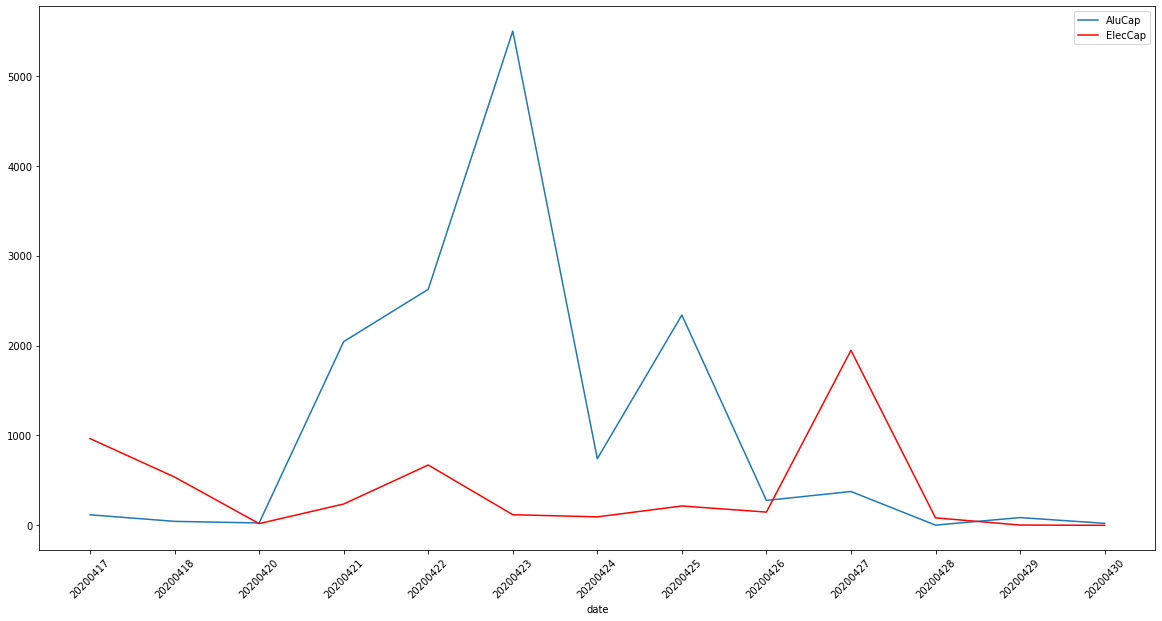

In [4]:
# gca stands for 'get current axis'
plt.figure(figsize=(20,10))
ax = plt.gca()
plt.xticks(range(len(alu)), df['date'])
df.plot(kind='line',x='date',y='AluCap',ax=ax, rot=45)
df.plot(kind='line',x='date',y='ElecCap', color='red', ax=ax, rot=45)
# ax.set_xticks(range(len(alu)))

# plt.show()
plt.savefig('041730_count_by_com.png')